In [1]:
git_repo = '../../..'

import sys
import os

sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib

# Local libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib

import matplotlib.pyplot as plt
%matplotlib inline

from copy import deepcopy

from autograd import numpy as np
from autograd import scipy as sp

# import numpy as np
# import scipy as sp

np.random.seed(453453)

import json 

In [2]:
# Load results from previous fit.
#filename = 'ryan_iris_bnp_full_data_fit_alpha8.0.json'
filename = 'ryan_simulation_bnp_full_data_fit_alpha8.0.json'
json_input_file = os.path.join(
    git_repo,
    'BNP_sensitivity/GMM_clustering/iris_fits/',
    filename)

with open(json_input_file, 'r') as fp:
    fit_dict = json.load(fp)
    model = gmm_utils.get_model_from_checkpoint(fit_dict)
    model_ = gmm_utils.get_model_from_checkpoint(fit_dict)
    best_param = model.global_vb_params.get_free()
    kl_hessian = gmm_utils.get_kl_hessian_from_checkpoint(fit_dict)

In [3]:
moment_model = gmm_utils.InterestingMoments(model)
dg_deta = moment_model.get_moment_jacobian(best_param)
linear_sens = gmm_utils.LinearSensitivity(model, moment_model, kl_hessian)

Prior Hessian...
Data Hessian...
Linear systems...
Done.


In [4]:
moment_model.set_moments_from_free_par(best_param)
print(moment_model.moment_params)

Moment parameters:
	centroids:
[[-0.89862729 -0.6051695  -1.50125936  0.06510113 -1.40330541  0.61287858
   0.30745596  0.25663505  1.72137636  1.43666097  0.99828602 -0.29476781]
 [-0.61805749  0.66819207 -1.51109677 -0.9374954  -1.50996968 -0.10084349
   0.42731808  1.23903035  1.75667923  0.06332253  0.92203725 -0.42054208]]
	cluster_weights:
[0.07983739 0.05978831 0.13052355 0.03176939 0.13426964 0.08658021
 0.07998455 0.06383699 0.00479492 0.04485727 0.05730031 0.22645748]
	v_sticks:
[-2.45022684 -2.67426143 -1.72439711 -3.1046676  -1.43766809 -1.71158407
 -1.60762942 -1.6592461  -4.3277428  -1.85377782 -1.38057936]


In [5]:
import functional_sensitivity_lib as fun_sens_lib
stick_sens = fun_sens_lib.StickSensitivity(model, best_param, kl_hessian, dg_deta.T)

[-10.81935519]


Text(0.5,1,'Perturbed prior')

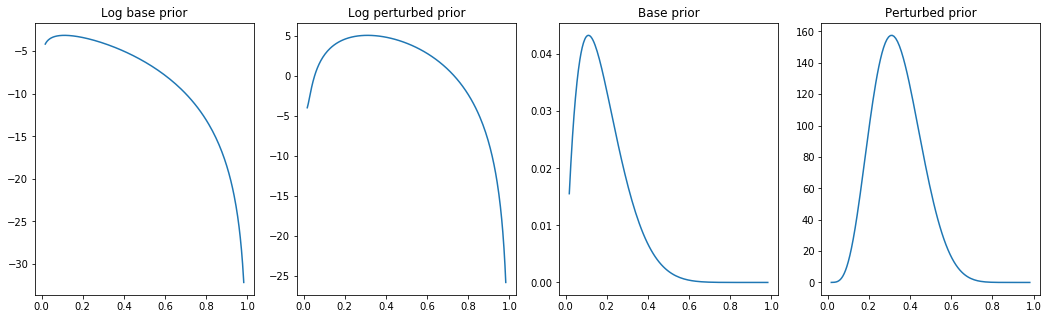

In [42]:

phi_center = 1
phi_log_rescale = stick_sens.get_log_p0_logit_stick(phi_center)
print(phi_log_rescale)
def log_phi(logit_v):
    return(-0.5 * (logit_v - phi_center) ** 2 - phi_log_rescale)

def phi(logit_v):
    return np.exp(log_phi(logit_v))

logit_v_grid = np.linspace(-4, 4, 200)
v_grid = np.exp(logit_v_grid) / (1 + np.exp(logit_v_grid))

plt.figure(1, figsize=(18, 5))

#plt.plot(v_grid, phi(logit_v_grid))
plt.subplot(141)
plt.plot(v_grid, stick_sens.get_log_p0_logit_stick(logit_v_grid))
plt.title('Log base prior')

plt.subplot(142)
plt.plot(v_grid, stick_sens.get_log_p0_logit_stick(logit_v_grid) + np.log(1 + phi(logit_v_grid)))
plt.title('Log perturbed prior')

plt.subplot(143)
#plt.plot(v_grid, np.log(1 + phi(logit_v_grid)))
plt.plot(v_grid, np.exp(stick_sens.get_log_p0_logit_stick(logit_v_grid)))
plt.title('Base prior')

plt.subplot(144)
plt.plot(v_grid, np.exp(stick_sens.get_log_p0_logit_stick(logit_v_grid) + np.log(1 + phi(logit_v_grid))))
plt.title('Perturbed prior')


In [7]:
# Choose the number of GH points.
import LinearResponseVariationalBayes.ExponentialFamilies as ef
model.global_vb_params.set_free(best_param)
vb_params = deepcopy(model.vb_params)

perturbed_log_density = lambda x : np.log(1.0 + phi(x))

expected_perturbations_list = []
gh_deg_list = np.arange(3, 100, 1)
for gh_deg in gh_deg_list:
    gmm_utils.set_gauss_hermite_points(vb_params, gh_deg=gh_deg)
    expected_perturbations_list.append(
        gmm_utils.get_e_log_perturbation_vec(vb_params, phi))

expected_perturbations_list = np.array(expected_perturbations_list)
#print(expected_perturbations_list.shape)
diffs = (expected_perturbations_list[1:, :] - \
         expected_perturbations_list[:-1, :]) / \
        np.abs(expected_perturbations_list[1:, :] + 1e-6)
#print(np.max(diffs, axis=1))
max_diffs = np.max(np.abs(diffs), axis=1) 
gh_deg_threshold = np.argmax(max_diffs < 1e-5)
gh_deg = max(20, gh_deg_threshold)
print(gh_deg, gh_deg_threshold, len(max_diffs))

20 9 96


In [8]:
# Check the gradients.

class PriorCheck(object):
    def __init__(self, model, phi):
        self.model = model
        self.global_vb_params = model.global_vb_params
        self.obj = obj_lib.Objective(
            self.global_vb_params, self.get_e_log_prior)
        self.phi = phi
    
    def get_e_log_prior(self):
        return np.sum(gmm_utils.get_e_log_perturbation_vec(
            self.model.vb_params, self.phi))

prior_check = PriorCheck(model, phi)
prior_check.obj.fun_free(best_param)
print('Should be non-zero: ', np.linalg.norm(prior_check.obj.fun_free_grad(best_param)))


Should be non-zero:  9.31930095570812


In [9]:
# # Check the model prior.
# def get_e_log_prior(model):
#     return np.squeeze(
#         gmm_utils.get_e_log_prior(
#             model.vb_params, model.prior_params, phi=model.phi))

# See whether or not phi is affecting the derivatives for debugging.
def check_model_phi(model):
    prior_obj = obj_lib.Objective(model.global_vb_params, model.get_e_log_prior)

    model.phi = None
    g1 = model.objective.fun_free_grad(best_param)

    model.phi = phi
    g2 = model.objective.fun_free_grad(best_param)

    print('Should be nonzero:', np.linalg.norm(g1 - g2))
    
    return g1, g2

check_model_phi(model);

Should be nonzero: 9.31930095570812


In [10]:
class PerturbedPrior(object):
    def __init__(self, model, phi, epsilon=0.0):
        self.phi = phi
        self.model = model
        self.epsilon_param = vb.ScalarParam('epsilon', lb=0.0)
        self.epsilon_param.set(epsilon)
        
    def epsilon_phi(self, x):
        return self.phi(x) * self.epsilon_param.get()
        
    def get_e_log_prior(self):
        return np.sum(gmm_utils.get_e_log_perturbation_vec(
            self.model.vb_params, self.epsilon_phi))
        
perturbed_prior = PerturbedPrior(model, phi)
perturbed_prior.get_e_log_prior()

0.0

In [11]:
eigv, eigvec = np.linalg.eig(kl_hessian)
np.max(eigv) / np.min(eigv)

5830.220132960141

In [19]:
# First fit with no perturbation but the increased number of gh points.
model.phi = None
gmm_utils.set_gauss_hermite_points(model.vb_params, gh_deg=gh_deg)

best_param_0, vb_opt_0, opt_time_0, \
kl_hessian_0, kl_hessian_corrected_0 = \
    model.precondition_and_optimize(
        best_param, kl_hessian=kl_hessian)

# best_param_0, kl_hessian_0, kl_hessian_corrected, \
# init_opt_time, newton_time, x_conv, f_conv, vb_opt = \
#     model_refit.optimize_full(
#         best_param,
#         init_max_iter=100,
#         final_max_iter=500)

print('Done. ')

Iter: 0	 RMSE: 11.859820226630768	 Objective: 424.4795462494185
         Current function value: 424.479546
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. 


In [20]:
eigv, eigvec = np.linalg.eig(kl_hessian_0)
print(np.max(eigv), np.min(eigv))

1045.284202712602 0.1792872616941629


In [21]:
epsilon_sensitivity = obj_lib.ParametricSensitivity(
    objective_fun=model.set_z_get_kl,
    input_par=model.global_vb_params,
    output_par=moment_model.moment_params,
    hyper_par=perturbed_prior.epsilon_param,
    input_to_output_converter=moment_model.set_moments,
    optimal_input_par=best_param_0,
    objective_hessian=kl_hessian_0,
    hyper_par_objective_fun=perturbed_prior.get_e_log_prior)

In [36]:
# Then fit with the perturbation.
log_epsilon = np.log(0.01)
def phi_eps(x):
    return np.exp(np.log(phi(x)) + log_epsilon)

model.phi = phi_eps
model.phi(0.2)
check_model_phi(model);

Should be nonzero: 9.319297717715475


In [37]:
best_param_phi, vb_opt_phi, opt_time_phi, \
kl_hessian_phi, kl_hessian_corrected_phi = \
    model_refit.precondition_and_optimize(
        best_param_0, kl_hessian=kl_hessian_0)

# best_param_phi, kl_hessian_phi, kl_hessian_corrected_phi, \
#     init_opt_time, newton_time, x_conv, f_conv, vb_opt = \
#     model.optimize_full(
#         best_param_0,
#         init_max_iter=100,
#         final_max_iter=500)

print('Done. ')

Iter: 60	 RMSE: 11.859820226630765	 Objective: 361.38068173586737
Iter: 70	 RMSE: 12.964373270158893	 Objective: 344.05437287684845
Iter: 80	 RMSE: 13.924131395252786	 Objective: 340.85075389999565
Iter: 90	 RMSE: 13.880376694243767	 Objective: 340.34127000833814
Iter: 100	 RMSE: 13.903510263695162	 Objective: 339.89422622178756
Iter: 110	 RMSE: 13.898560776358652	 Objective: 339.89296256223236
         Current function value: 339.892963
         Iterations: 58
         Function evaluations: 60
         Gradient evaluations: 41
         Hessian evaluations: 0
Done. 


In [38]:
print('This is nonzero if phi did anything:', np.linalg.norm(best_param_phi - best_param_0))

This is nonzero if phi did anything: 6.633303285714625


In [40]:
epsilon = np.exp(log_epsilon)
best_param_phi_pred = epsilon_sensitivity.predict_input_par_from_hyperparameters(epsilon)
output_phi_pred = epsilon_sensitivity.predict_output_par_from_hyperparameters(epsilon, linear=True)

moment_model.set_moments_from_free_par(best_param_phi)
output_phi = moment_model.moment_params.get_vector()

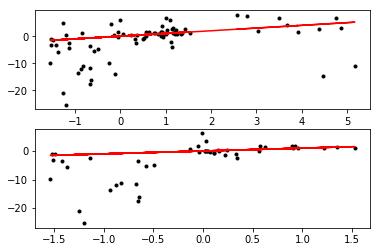

In [41]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(best_param_phi, best_param_phi_pred, 'k.')
plt.plot(best_param_phi, best_param_phi, 'r')

plt.subplot(2, 1, 2)
plt.plot(output_phi, output_phi_pred, 'k.')
plt.plot(output_phi, output_phi, 'r')

In [ ]:
##################
# Old:

In [ ]:
stick_sens = fun_sens_lib.StickSensitivity(model, best_param, kl_hessian, dg_deta.T)

In [ ]:
influence_vals = np.array([
    stick_sens.get_all_stick_influence(logit_v) for logit_v in logit_v_grid ])

In [ ]:
def get_log_q_grad_vec(self, logit_v):
    log_q_grad_vec = np.array([
        self.log_q_logit_stick_obj.fun_free_grad(
            self.best_param, logit_v=logit_v, k=k)
        for k in range(self.model.k_approx - 1) ])
    return log_q_grad_vec
log_q_grads = np.array([ get_log_q_grad_vec(stick_sens, logit_v) for logit_v in logit_v_grid ])

In [ ]:
log_p0 = stick_sens.get_log_p0_logit_stick(logit_v_grid)
log_q_vec = np.array([
    stick_sens.get_log_q_logit_all_sticks(logit_v) \
    for logit_v in logit_v_grid ])

print(log_q_grads.shape)
print(log_p0.shape)
print(log_q_vec.shape)


In [ ]:
def get_all_stick_influence_times_phi(self, logit_v_grid, log_q_grads, log_phi, log_epsilon=0):
    # The prior is the same for every stick.
    log_p0 = stick_sens.get_log_p0_logit_stick(logit_v_grid)[:, np.newaxis]
    log_perturbation = log_phi(logit_v_grid)[:, np.newaxis] + log_epsilon
    log_q_vec = np.array([
        stick_sens.get_log_q_logit_all_sticks(logit_v) \
        for logit_v in logit_v_grid ])

    #print(log_q_vec.shape)
    #print(log_p0.shape)
    #print(log_perturbation.shape)
    
    #dens_ratios = np.exp(log_q_vec - log_p0 + log_perturbation)
    dens_ratios = np.exp(log_q_vec + log_perturbation)
    #print(self.lr_mat.shape)
    #print(log_q_grads.shape)
    #print(dens_ratios.shape)
    
    # d indexes the free parameters
    # g indexes the moments of interest
    # n indexes the grid points in logit_v_grid
    # k indexes the stick
    return(np.einsum('dg,nkd,nk->ng', self.lr_mat, log_q_grads, dens_ratios))

influence_phi_vals = \
    get_all_stick_influence_times_phi(
        stick_sens, logit_v_grid, log_q_grads, log_phi, log_epsilon=log_epsilon)

In [ ]:
#plt.plot(logit_v_grid, influence_phi_vals[:, 0]);
plt.plot(logit_v_grid[1:], (np.diff(logit_v_grid)[:, np.newaxis] * influence_phi_vals[1:,0]).T);

In [ ]:
def get_moments(free_par, moment_model):
    moment_model_copy = deepcopy(moment_model)
    moment_model_copy.set_moments_from_free_par(free_par)
    return moment_model.moment_params.get_vector()

pred_influence = np.sum(
    np.diff(logit_v_grid)[:, np.newaxis] * influence_phi_vals[1:,:], axis=0)
print(pred_influence.shape)

true_moment_diff = get_moments(best_param_phi, moment_model) - get_moments(best_param_0, moment_model)

In [ ]:
plt.plot(pred_influence, true_moment_diff, 'k.')
plt.plot(true_moment_diff, true_moment_diff, 'r')